# Кодирование категориальных признаков

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

## Загрузка и предобработка данных

Используем данные из соревнования [Titanic](https://www.kaggle.com/c/titanic/)

In [2]:
# Будем использовать только обучающую выборку
data_loaded = pd.read_csv('data/titanic.csv', sep=",")

In [3]:
# размер набора данных
data_loaded.shape

(891, 12)

In [4]:
data_loaded.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
data_features = list(zip(
# признаки
[i for i in data_loaded.columns],
zip(
    # типы колонок
    [str(i) for i in data_loaded.dtypes],
    # проверим есть ли пропущенные значения
    [i for i in data_loaded.isnull().sum()]
)))
# Признаки с типом данных и количеством пропусков
data_features

[('PassengerId', ('int64', 0)),
 ('Survived', ('int64', 0)),
 ('Pclass', ('int64', 0)),
 ('Name', ('object', 0)),
 ('Sex', ('object', 0)),
 ('Age', ('float64', 177)),
 ('SibSp', ('int64', 0)),
 ('Parch', ('int64', 0)),
 ('Ticket', ('object', 0)),
 ('Fare', ('float64', 0)),
 ('Cabin', ('object', 687)),
 ('Embarked', ('object', 2))]

In [6]:
# Используем только некоторые признаки
cols_filter = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
        'Sex', 'Cabin', 'Embarked', 'Survived']
data = data_loaded[cols_filter]
data.head()

,Pclass,Age,SibSp,Parch,Fare,Sex,Cabin,Embarked,Survived
0,3,22.0,1,0,7.2500,male,NaN,S,0
1,1,38.0,1,0,71.2833,female,C85,C,1
2,3,26.0,0,0,7.9250,female,NaN,S,1
3,1,35.0,1,0,53.1000,female,C123,S,1
4,3,35.0,0,0,8.0500,male,NaN,S,0


In [7]:
# Заполним пропуски
data.dropna(subset=['Fare', 'Embarked'], inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [8]:
# От каюты оставляет только первую букву 
# и убираем каюты типа Т так как их мало
data['Cabin'] = data['Cabin'].astype(str).str[0]
data = data[data['Cabin'] != 'T']

C:\Users\Paladin\AppData\Local\Temp/ipykernel_9088/3362610652.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cabin'] = data['Cabin'].astype(str).str[0]


In [9]:
# Заполним пропуски возраста средними значениями
def impute_na(df, variable, value):
    df[variable].fillna(value, inplace=True)
impute_na(data, 'Age', data['Age'].mean())

In [10]:
# Убедимся что нет пустых значений
data.isnull().sum()

Pclass      0
Age         0
SibSp       0
Parch       0
Fare        0
Sex         0
Cabin       0
Embarked    0
Survived    0
dtype: int64

## 1. Кодирование категорий целочисленными значениями - [label encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

Label Encoding (LE), который также называют integer encoding, предполагает, что значения категорий заменяются целыми числами в случайном порядке. 

#### Преимущества:
- Простота реализации.
- Не расширяется признаковое пространство (не появляется дополнительных колонок).

#### Недостатки:
- Не использует информацию о распределении значений категорий.
- Не подходит для линейных моделей, так как создает фиктивное отношение порядка между значениями.

In [11]:
from sklearn.preprocessing import LabelEncoder

In [12]:
le = LabelEncoder()
cat_enc_le = le.fit_transform(data['Cabin'])

In [13]:
data['Cabin'].unique()

array(['n', 'C', 'E', 'G', 'D', 'A', 'B', 'F'], dtype=object)

In [14]:
np.unique(cat_enc_le)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [15]:
le.inverse_transform([0, 1, 2, 3])

array(['A', 'B', 'C', 'D'], dtype=object)

Для целочисленного кодирования также можно использовать [метод ordinal библиотеки Category Encoders.](https://contrib.scikit-learn.org/category_encoders/ordinal.html) Для того чтобы учесть возможное отношение порядка между значениями категорий, в качестве параметра mapping можно передавать словарь соответствий между значениями  категорий и кодирующими их числами. 

## 2. Кодирование категорий наборами бинарных значений - [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

One-hot encoding предполагает, что значение категории заменяется на отдельную колонку, которая содержит бинарные значения.

#### Преимущества:
- Простота реализации.
- Подходит для любых моделей, так как НЕ создает фиктивное отношение порядка между значениями.

#### Недостатки:
- Расширяется признаковое пространство.


In [16]:
from sklearn.preprocessing import OneHotEncoder

In [17]:
ohe = OneHotEncoder()
cat_enc_ohe = ohe.fit_transform(data[['Cabin']])
cat_enc_ohe

<888x8 sparse matrix of type '<class 'numpy.float64'>'
	with 888 stored elements in Compressed Sparse Row format>

In [18]:
cat_enc_ohe.todense()[0:10]

matrix([[0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1.]])

### [Pandas get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) - быстрый вариант one-hot кодирования

Преимущество в том, что возвращается Pandas DataFrame.

In [19]:
pd.get_dummies(data[['Cabin']]).head()

,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_n
0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,1


In [20]:
# Добавление отдельной колонки, признака пустых значений
pd.get_dummies(data[['Cabin']], dummy_na=True).head()

,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_n,Cabin_nan
0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0


### Использование библиотеки [Сategory Encoders](https://contrib.scikit-learn.org/category_encoders/index.html)

In [21]:
from category_encoders.one_hot import OneHotEncoder as ce_OneHotEncoder

In [22]:
ce_OneHotEncoder1 = ce_OneHotEncoder()
data_OHE = ce_OneHotEncoder1.fit_transform(data[data.columns.difference(['Survived'])])

In [23]:
data_OHE

,Age,Cabin_1,Cabin_2,Cabin_3,Cabin_4,Cabin_5,Cabin_6,Cabin_7,Cabin_8,Embarked_1,Embarked_2,Embarked_3,Fare,Parch,Pclass,Sex_1,Sex_2,SibSp
0,22.000000,1,0,0,0,0,0,0,0,1,0,0,7.2500,0,3,1,0,1
1,38.000000,0,1,0,0,0,0,0,0,0,1,0,71.2833,0,1,0,1,1
2,26.000000,1,0,0,0,0,0,0,0,1,0,0,7.9250,0,3,0,1,0
3,35.000000,0,1,0,0,0,0,0,0,1,0,0,53.1000,0,1,0,1,1
4,35.000000,1,0,0,0,0,0,0,0,1,0,0,8.0500,0,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.000000,1,0,0,0,0,0,0,0,1,0,0,13.0000,0,2,1,0,0
887,19.000000,0,0,0,0,0,0,1,0,1,0,0,30.0000,0,1,0,1,0
888,29.620492,1,0,0,0,0,0,0,0,1,0,0,23.4500,2,3,0,1,1
889,26.000000,0,1,0,0,0,0,0,0,0,1,0,30.0000,0,1,1,0,0


## 3. Count (frequency) encoding

![](img/count_frequency_encoding.png)

Count encoding предполагает что значение категории заменяется на количество раз, которое оно встречается в категории.

В случае frequency encoding вместо количества используется доля (процент) от количества записей.

#### Преимущества:
- Простота реализации.
- Не расширяется признаковое пространство.

#### Недостатки:
- Если два значения встречаются одинаковое количество раз, то они будут заменены на одно и то же количество и становятся неразличимы.


### Использование библиотеки [Сategory Encoders](https://contrib.scikit-learn.org/category_encoders/index.html)

In [24]:
from category_encoders.count import CountEncoder as ce_CountEncoder

In [25]:
ce_CountEncoder1 = ce_CountEncoder()
data_COUNT_ENC = ce_CountEncoder1.fit_transform(data[data.columns.difference(['Survived'])])

In [26]:
data_COUNT_ENC

,Age,Cabin,Embarked,Fare,Parch,Pclass,Sex,SibSp
0,22.000000,687,643,7.2500,0,3,576,1
1,38.000000,59,168,71.2833,0,1,312,1
2,26.000000,687,643,7.9250,0,3,312,0
3,35.000000,59,643,53.1000,0,1,312,1
4,35.000000,687,643,8.0500,0,3,576,0
...,...,...,...,...,...,...,...,...
886,27.000000,687,643,13.0000,0,2,576,0
887,19.000000,45,643,30.0000,0,1,312,0
888,29.620492,687,643,23.4500,2,3,312,1
889,26.000000,59,168,30.0000,0,1,576,0


In [27]:
data['Cabin'].unique()

array(['n', 'C', 'E', 'G', 'D', 'A', 'B', 'F'], dtype=object)

In [28]:
data_COUNT_ENC['Cabin'].unique()

array([687,  59,  32,   4,  33,  15,  45,  13], dtype=int64)

In [29]:
ce_CountEncoder2 = ce_CountEncoder(normalize=True)
data_FREQ_ENC = ce_CountEncoder2.fit_transform(data[data.columns.difference(['Survived'])])

In [30]:
data_FREQ_ENC

,Age,Cabin,Embarked,Fare,Parch,Pclass,Sex,SibSp
0,22.000000,0.773649,0.724099,7.2500,0,3,0.648649,1
1,38.000000,0.066441,0.189189,71.2833,0,1,0.351351,1
2,26.000000,0.773649,0.724099,7.9250,0,3,0.351351,0
3,35.000000,0.066441,0.724099,53.1000,0,1,0.351351,1
4,35.000000,0.773649,0.724099,8.0500,0,3,0.648649,0
...,...,...,...,...,...,...,...,...
886,27.000000,0.773649,0.724099,13.0000,0,2,0.648649,0
887,19.000000,0.050676,0.724099,30.0000,0,1,0.351351,0
888,29.620492,0.773649,0.724099,23.4500,2,3,0.351351,1
889,26.000000,0.066441,0.189189,30.0000,0,1,0.648649,0


In [31]:
data_FREQ_ENC['Cabin'].unique()

array([0.77364865, 0.06644144, 0.03603604, 0.0045045 , 0.03716216,
       0.01689189, 0.05067568, 0.01463964])

## 4. Target (Mean) encoding

![](img/target_encoding.png)

Target encoding предполагает что значение категории заменяется на ранг, соответствующий среднему значению целевого признака для этой категории.

В случае Mean encoding в кодируемый признак подставляется усредненное значение целевого признака.

Фактически, ранг зависит от вероятности появления целевого признака, при условии, что кодируемый признак принимает определенное значение.

Кодирование признака управляется значением целевого признака, возникает монотонная зависимость между кодируемым признаком и целевым признаком.

#### Преимущества:
- Наличие монотонной зависимости.
- Не расширяется признаковое пространство.

#### Недостатки:
- Может привести к переобучению.
- Сложность использования с библиотеками кросс-валидации.


### Использование библиотеки [Сategory Encoders](https://contrib.scikit-learn.org/category_encoders/index.html)

In [32]:
# На самом деле этот метод реализует Mean encoding
from category_encoders.target_encoder import TargetEncoder as ce_TargetEncoder

In [33]:
ce_TargetEncoder1 = ce_TargetEncoder()
data_MEAN_ENC = ce_TargetEncoder1.fit_transform(data[data.columns.difference(['Survived'])], data['Survived'])

In [34]:
data_MEAN_ENC

,Age,Cabin,Embarked,Fare,Parch,Pclass,Sex,SibSp
0,22.000000,0.299854,0.337481,7.2500,0,3,0.189236,1
1,38.000000,0.593220,0.553571,71.2833,0,1,0.740385,1
2,26.000000,0.299854,0.337481,7.9250,0,3,0.740385,0
3,35.000000,0.593220,0.337481,53.1000,0,1,0.740385,1
4,35.000000,0.299854,0.337481,8.0500,0,3,0.189236,0
...,...,...,...,...,...,...,...,...
886,27.000000,0.299854,0.337481,13.0000,0,2,0.189236,0
887,19.000000,0.733333,0.337481,30.0000,0,1,0.740385,0
888,29.620492,0.299854,0.337481,23.4500,2,3,0.740385,1
889,26.000000,0.593220,0.553571,30.0000,0,1,0.189236,0


In [35]:
# Проверка для поля "Пол"
data['Sex'].unique()

array(['male', 'female'], dtype=object)

In [36]:
data_MEAN_ENC['Sex'].unique()

array([0.18923611, 0.74038462])

In [37]:
def check_mean_encoding(field):
    for s in data[field].unique():
        data_filter = data[data[field]==s]
        if data_filter.shape[0] > 0:
            prob = sum(data_filter['Survived']) / data_filter.shape[0]
            print(s, '-' , prob)

In [38]:
check_mean_encoding('Sex')

male - 0.1892361111111111
female - 0.7403846153846154


In [39]:
# Проверка для поля "Каюта"
data_MEAN_ENC['Cabin'].unique()

array([0.29985444, 0.59322034, 0.75      , 0.49444562, 0.75757576,
       0.4666666 , 0.73333333, 0.61538319])

In [40]:
check_mean_encoding('Cabin')

n - 0.29985443959243085
C - 0.5932203389830508
E - 0.75
G - 0.5
D - 0.7575757575757576
A - 0.4666666666666667
B - 0.7333333333333333
F - 0.6153846153846154


## 5. Weight of evidence (WoE) encoding

$$ WoE = \ln\Big(\frac{\text{Пропорция хороших событий}}{\text{Пропорция плохих  событий}}\Big) $$

$$ \text{Пропорция хороших (плохих) событий} = \frac{\text{Количество хороших (плохих) событий для заданного значения категории}}{\text{Общее количество хороших (плохих) событий}} $$


Кодирование признака управляется значением целевого признака, возникает монотонная зависимость между кодируемым признаком и целевым признаком.

#### Преимущества:
- Наличие монотонной зависимости.
- Хорошо подходит для логистической регресии.

#### Недостатки:
- Может привести к переобучению.


### Использование библиотеки [Сategory Encoders](https://contrib.scikit-learn.org/category_encoders/index.html)

In [41]:
from category_encoders.woe import WOEEncoder as ce_WOEEncoder

In [42]:
ce_WOEEncoder1 = ce_WOEEncoder()
data_WOE_ENC = ce_WOEEncoder1.fit_transform(data[data.columns.difference(['Survived'])], data['Survived'])

In [43]:
data_WOE_ENC

,Age,Cabin,Embarked,Fare,Parch,Pclass,Sex,SibSp
0,22.000000,-0.370118,-0.197181,7.2500,0,3,-0.972880,1
1,38.000000,0.839751,0.687669,71.2833,0,1,1.515126,1
2,26.000000,-0.370118,-0.197181,7.9250,0,3,1.515126,0
3,35.000000,0.839751,-0.197181,53.1000,0,1,1.515126,1
4,35.000000,-0.370118,-0.197181,8.0500,0,3,-0.972880,0
...,...,...,...,...,...,...,...,...
886,27.000000,-0.370118,-0.197181,13.0000,0,2,-0.972880,0
887,19.000000,1.436519,-0.197181,30.0000,0,1,1.515126,0
888,29.620492,-0.370118,-0.197181,23.4500,2,3,1.515126,1
889,26.000000,0.839751,0.687669,30.0000,0,1,-0.972880,0


In [44]:
# Проверка для поля "Пол"
data['Sex'].unique()

array(['male', 'female'], dtype=object)

In [45]:
data_WOE_ENC['Sex'].unique()

array([-0.97288039,  1.51512567])

In [46]:
def check_woe_encoding(field):
    data_ones = data[data['Survived'] == 1].shape[0]
    data_zeros = data[data['Survived'] == 0].shape[0]
    
    for s in data[field].unique():
        data_filter = data[data[field]==s]
        if data_filter.shape[0] > 0:
            
            filter_data_ones = data_filter[data_filter['Survived'] == 1].shape[0]
            filter_data_zeros = data_filter[data_filter['Survived'] == 0].shape[0]

            good = filter_data_ones / data_ones
            bad = filter_data_zeros / data_zeros
            
            woe = np.log(good/bad)
            print(s, '-' , woe)

In [47]:
check_woe_encoding('Sex')

male - -0.977651706101945
female - 1.5252982251871632


In [48]:
# Проверка для поля "Каюта"
data_WOE_ENC['Cabin'].unique()

array([-0.37011778,  0.83975065,  1.49675879,  0.47510754,  1.5359795 ,
        0.35732451,  1.43651871,  0.88057265])

In [49]:
check_woe_encoding('Cabin')

n - -0.3706614319783718
C - 0.8546239004792764
E - 1.5759419580059182
G - 0.4773296693378085
D - 1.6167639525261734
A - 0.3437982767132859
B - 1.4889305810162885
F - 0.9473332985835441


## 6.  Helmert encoding

Используется для упорядоченных категориальных переменных.

Cравнивает каждый уровень категориальной переменной со средним значением последующих уровней.

[Детальное пояснение алгоритма кодирования.](https://stats.stackexchange.com/questions/411134/how-to-calculate-helmert-coding)


### Использование библиотеки [Сategory Encoders](https://contrib.scikit-learn.org/category_encoders/index.html)

In [50]:
from category_encoders.helmert import HelmertEncoder as ce_HelmertEncoder

In [51]:
ce_HelmertEncoder1 = ce_HelmertEncoder()
data_HELM_ENC = ce_HelmertEncoder1.fit_transform(data[data.columns.difference(['Survived'])], data['Survived'])

In [52]:
data_HELM_ENC

,intercept,Age,Cabin_0,Cabin_1,Cabin_2,Cabin_3,Cabin_4,Cabin_5,Cabin_6,Embarked_0,Embarked_1,Fare,Parch,Pclass,Sex_0,SibSp
0,1,22.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,7.2500,0,3,-1.0,1
1,1,38.000000,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,71.2833,0,1,1.0,1
2,1,26.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,7.9250,0,3,1.0,0
3,1,35.000000,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,53.1000,0,1,1.0,1
4,1,35.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,8.0500,0,3,-1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,1,27.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,13.0000,0,2,-1.0,0
887,1,19.000000,0.0,0.0,0.0,0.0,0.0,6.0,-1.0,-1.0,-1.0,30.0000,0,1,1.0,0
888,1,29.620492,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,23.4500,2,3,1.0,1
889,1,26.000000,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,30.0000,0,1,-1.0,0


## Обучение моделей с различными вариантами предобработки признаков

In [53]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()    

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [55]:
clas_models_dict = {'LogR': LogisticRegression(max_iter=1000), 
                    'KNN_5':KNeighborsClassifier(n_neighbors=5),
                    'Tree':DecisionTreeClassifier(),
                    'GB': GradientBoostingClassifier(),
                    'RF':RandomForestClassifier(n_estimators=50, random_state=1, max_depth=3)}

In [56]:
X_data_dict = {'One-Hot encoding': data_OHE, 
               'Count encoding': data_COUNT_ENC,
               'Frequency encoding': data_FREQ_ENC, 
               'Mean encoding': data_MEAN_ENC,
               'Weight of evidence encoding': data_WOE_ENC,
               'Helmert encoding': data_HELM_ENC}

In [57]:
def test_models(clas_models_dict, X_data_dict, y_data):
    
    logger = MetricLogger()
    
    for model_name, model in clas_models_dict.items():
        
        for data_name, X_data in X_data_dict.items():
    
            X_train, X_test, y_train, y_test = train_test_split(
                X_data, y_data, test_size=0.3, random_state=1)
        
            model.fit(X_train, y_train)
            pred1 = model.predict_proba(X_train)
            pred2 = model.predict_proba(X_test)
            roc_auc = roc_auc_score(y_test, pred2[:, 1])
            logger.add(model_name, data_name, roc_auc)
            
    return logger

In [58]:
%%time
logger = test_models(clas_models_dict, X_data_dict, data['Survived'])

Wall time: 1.96 s


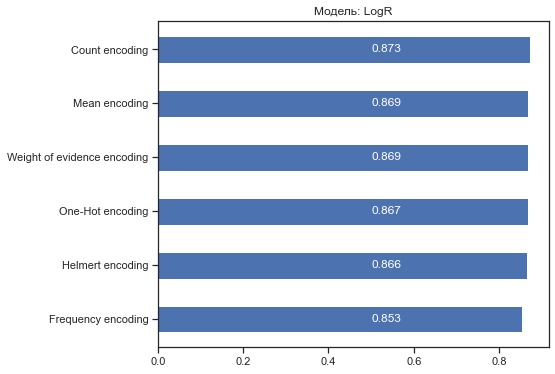

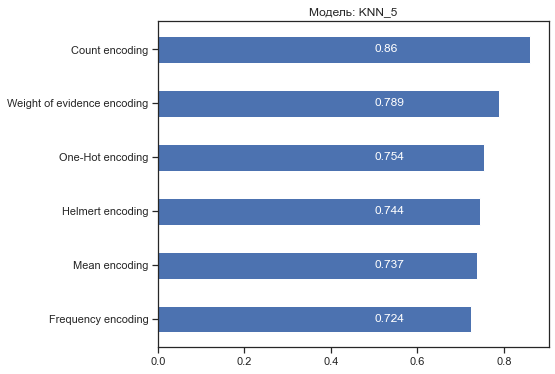

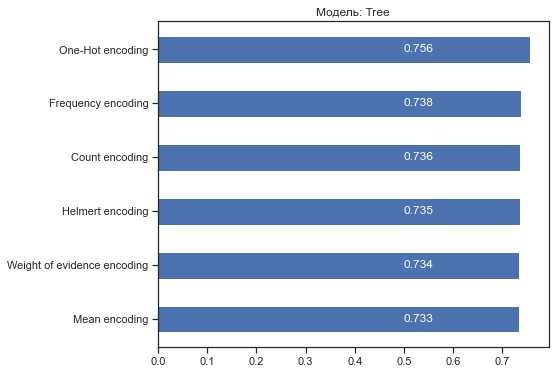

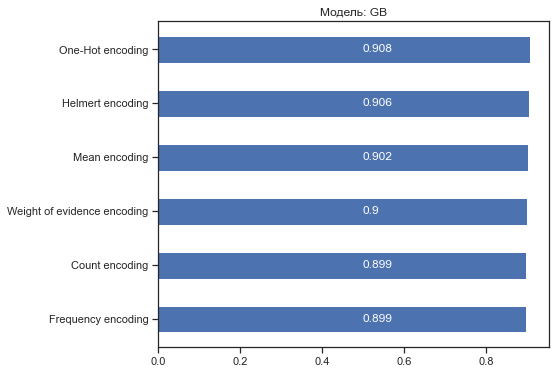

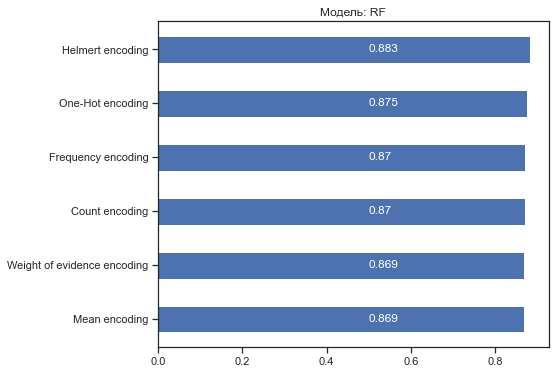

In [59]:
# Построим графики метрик качества модели
for model in clas_models_dict:
    logger.plot('Модель: ' + model, model, figsize=(7, 6))